In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
import tensorflow as tf
import onnx
import onnxruntime as ort


# set the legend frame
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'black'
plt.rcParams['legend.framealpha'] = 1

# set the line width
plt.rcParams['lines.linewidth'] = 2

# set the point size
plt.rcParams['lines.markersize'] = 8

# set the error bar capsize
plt.rcParams['errorbar.capsize'] = 5

# set the font size
plt.rcParams['font.size'] = 16

# set the figure dpi
#plt.rcParams['figure.dpi'] = 192

# set the save figure format
plt.rcParams['savefig.format'] = 'pdf'

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper")


networks = ["mlp", "mlp_wide", "mlp_deep", "mlp_deep_wide", "mlp_conv", "conv1d", "conv2d", "depthwise_conv1d", "separable_conv2d", "separable_conv1d", "mlp_piecewise", "mlp_repeat", "mlp_big", "mlp_piecewise2", "lstm", "mlp_small"]




/home/zaptos/miniconda3/envs/trackml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-11 07:33:36.358223: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-11 07:33:36.942806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
version = "0.0.0"
old_cluster = "7473664"
fl = 16

if version[2] == "0":
    windowsize = 3
else:
    windowsize = 4
    
# Load the data
if version[-1] == "0":
    inpu = np.load(f"../../Data/test_data_{windowsize}/test_input.npy")
    inpu_id = np.load(f"../../Data/test_data_{windowsize}/test_id.npy")
else:
    inpu = np.load(f"../../Data/test_data_{windowsize}_backwards/test_input.npy")
    inpu_id = np.load(f"../../Data/test_data_{windowsize}_backwards/test_id.npy")

if version[-1] == "0":
    true_data = np.load(f"../../Data/test_data_{windowsize}/test_target.npy")
else:
    true_data = np.load(f"../../Data/test_data_{windowsize}_backwards/test_target.npy")

In [ ]:
minloss = []
for i, network in enumerate(networks):
    loss = pickle.load(open(f"../../final/loss_info/{network}{old_cluster}.pkl", "rb"))
    # Calculate the test loss
    model = tf.keras.models.load_model(f"../../final/models/tensorflow/{network}_{version}_{old_cluster}", compile=False)
    model.load_weights(f"../../final/checkpoints/{network}{old_cluster}/{network}{old_cluster}")
    model.compile(optimizer='adam', loss='mse')
    if network == "mlp_small":
        testloss = model.evaluate(inpu, true_data, verbose=0)
    else:
        testloss = model.evaluate((inpu, inpu_id), true_data, verbose=0)
    plt.semilogy(loss['loss'],'s', color='orangered', label='Training Loss', markersize=4)
    plt.semilogy(loss['val_loss'],'o', color='k', label='Validation Loss', markersize=1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0,1e-3)
    plt.legend()
    plt.grid()
    plt.title(network+f' Loss for window size of {windowsize}'+ (" inside-out" if version[-1]=="0" else " outside-in"))
    # Insert the minimum loss and the epoch at which it was achieved with 3 digit precision
    # make a box like the legend with the minimum loss and the epoch at which it was achieved with 3 digit precision
    if network == "separable_conv2d":
        plt.text(1000, 6e-4, f"Min Validation Loss: {min(loss['val_loss']):.3g}\nEpoch: {np.argmin(loss['val_loss'])}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        plt.text(1000, 5e-4, f"Min Training Loss: {min(loss['loss']):.3g}\nEpoch: {np.argmin(loss['loss'])}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        plt.text(1000, 4.5e-4, f"Testing Loss: {testloss:.3g}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    elif network == "mlp_small":
        plt.text(1000, 2e-4, f"Min Validation Loss: {min(loss['val_loss']):.3g}\nEpoch: {np.argmin(loss['val_loss'])}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        plt.text(1000, 3e-4, f"Min Training Loss: {min(loss['loss']):.3g}\nEpoch: {np.argmin(loss['loss'])}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        plt.text(1000, 1.2e-4, f"Testing Loss: {testloss:.3g}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    else:
        plt.text(1000, 2e-4, f"Min Validation Loss: {min(loss['val_loss']):.3g}\nEpoch: {np.argmin(loss['val_loss'])}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        plt.text(1000, 1e-4, f"Min Training Loss: {min(loss['loss']):.3g}\nEpoch: {np.argmin(loss['loss'])}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        plt.text(1000, 6e-5, f"Testing Loss: {testloss:.3g}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    #plt.show()
    #plt.savefig(f"../../final/loss_plot/{network}_{version}.pdf")
    plt.close()
    print(f"Network: {network}")
    print(f"Loss: {min(loss['val_loss'])}")
    minloss.append(min(loss['val_loss']))
    print(f"Epoch: {np.argmin(loss['val_loss'])}")


In [ ]:

amount = 10_000
if fl == 16:
    inpu = inpu.astype(np.float16)
    inpu_id = inpu_id.astype(np.float16)
else:
    inpu = inpu.astype(np.float32)
    inpu_id = inpu_id.astype(np.float32)
    networks += ["dart1", "dart2", "rf1", "rf2", "gbdt1", "gbdt2"]
stds = []
for network in networks:
    if network != "dart1" and network != "dart2" and network != "rf1" and network != "rf2" and network != "gbdt1" and network != "gbdt2":
        if version[-1] == "0":
            true_data = np.load(f"../../Data/test_data_{windowsize}/test_target.npy")
        else:
            true_data = np.load(f"../../Data/test_data_{windowsize}_backwards/test_target.npy")
        true_data[:, 0] = true_data[:, 0] * 1015
        true_data[:, 1] = true_data[:, 1] * 1015
        true_data[:, 2] = true_data[:, 2] * 3000
        if fl == 16:
            init_model = onnx.load(f"../../final/models/onnx/{network}_{version}_fp16_{old_cluster}.onnx")
        else:
            init_model = onnx.load(f"../../final/models/onnx/{network}_{version}_{old_cluster}.onnx")
        ort_session = ort.InferenceSession(init_model.SerializeToString())
        # The input name is the name of the input layer
        input_dict = {}
        for i, name in enumerate(ort_session.get_inputs()):
            if i == 0:
                input_dict[name.name] = inpu.reshape(-1,*ort_session.get_inputs()[0].shape[1:])
            if i == 1:
                input_dict[name.name] = inpu_id.reshape(-1,*ort_session.get_inputs()[1].shape[1:])
        data = ort_session.run([ort_session.get_outputs()[0].name], input_dict)[0]
    elif network[-1] == "1":
        data = np.vstack((np.load(f"../../final/models/verstack/tuned0_predict_{network[:-1]}_{version}.npy"), np.load(f"../../final/models/verstack/tuned1_predict_{network[:-1]}_{version}.npy"), np.load(f"../../final/models/verstack/tuned2_predict_{network[:-1]}_{version}.npy"))).T
        true_data = np.vstack((np.load(f"../../final/models/verstack/y0_{version}.npy"), np.load(f"../../final/models/verstack/y1_{version}.npy"), np.load(f"../../final/models/verstack/y2_{version}.npy"))).T
        true_data[:, 0] = true_data[:, 0] * 1015
        true_data[:, 1] = true_data[:, 1] * 1015
        true_data[:, 2] = true_data[:, 2] * 3000

    elif network[-1] == "2":
        data = np.vstack((np.load(f"../../final/models/verstack/tuned01_predict_{network[:-1]}_{version}.npy"), np.load(f"../../final/models/verstack/tuned11_predict_{network[:-1]}_{version}.npy"), np.load(f"../../final/models/verstack/tuned21_predict_{network[:-1]}_{version}.npy"))).T
        true_data = np.vstack((np.load(f"../../final/models/verstack/y0_{version}.npy"), np.load(f"../../final/models/verstack/y1_{version}.npy"), np.load(f"../../final/models/verstack/y2_{version}.npy"))).T
        true_data[:, 0] = true_data[:, 0] * 1015
        true_data[:, 1] = true_data[:, 1] * 1015
        true_data[:, 2] = true_data[:, 2] * 3000
    else:
        raise ValueError("Network not found")

    # Run the model
    
    data[:, 0] = data[:, 0] * 1015
    data[:, 1] = data[:, 1] * 1015
    data[:, 2] = data[:, 2] * 3000
    
    std = np.std(data - true_data, axis=0)
    stds.append(std)
    mean = np.mean(data - true_data, axis=0)
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    for j in range(3):
        sns.histplot(data[:, j] - true_data[:, j],bins=200, ax=ax[j], edgecolor='black', linewidth=0.5)
        ax[j].set_ylabel("")
        ax[j].set_title(f"{['x[mm]', 'y[mm]', 'z[mm]'][j]}")
        ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)        
        if j == 2:
            ax[j].set_xlim(-50,50)
        else:
            ax[j].set_xlim(-20,20)
        # Make a legend that shows the mean and std of the difference in x and y and z between the true and predicted values per axis   
        ax[j].legend([f"mean: {mean[j]:.2f}, std: {std[j]:.2f}"])
        ax[j].grid()
    # Make one x label and one y label for the whole figure
    fig.text(0.5, 0, 'Difference between predicted and true', ha='center')
    fig.text(0, 0.5, 'Count', va='center', rotation='vertical')
    # Make a title for the whole figure
    fig.suptitle(f"{network} performance for window size of {windowsize}" + (" inside-out" if version[-1] == "0" else " outside-in") + f" with float{fl}")
    plt.tight_layout()
    #plt.show()
    if fl == 16 and network != "dart1" and network != "dart2" and network != "rf1" and network != "rf2" and network != "gbdt1" and network != "gbdt2":
        plt.savefig(f"../../final/histogram/{network}_{version}_fp16.pdf")
    else:
        plt.savefig(f"../../final/histogram/{network}_{version}.pdf")
    plt.close()

    # Make a scatter plot of x and y axis of the true and predicted values with the true and predicted values as different colors and x and z


    fig, ax = plt.subplots(1, 2, figsize=(10, 6))

    ax[0].scatter(data[:amount, 0], data[:amount, 1], label="predicted", s=1)
    ax[0].scatter(true_data[:amount, 0], true_data[:amount, 1], label="true", s=1)
    ax[0].set_xlabel("x [mm]")
    ax[0].set_ylabel("y [mm]")
    ax[0].grid()
    ax[0].legend()


    ax[1].scatter(data[:amount, 2], np.sqrt(data[:amount, 0]**2 + data[:amount,1]**2), label="predicted", s=1)
    ax[1].scatter(true_data[:amount, 2], np.sqrt(true_data[:amount, 0]**2 + true_data[:amount,1]**2), label="true", s=1)
    ax[1].set_xlabel("z [mm]")
    ax[1].set_ylabel("r [mm]")
    ax[1].grid()
    ax[1].legend()
    fig.suptitle(f"{network} x-y and z-r scatter plot for window size of {windowsize}" + (" inside-out" if version[-1] == "0" else " outside-in") + f" with float{fl}")
    #plt.tight_layout()
    #plt.show()
    if fl == 16 and network != "dart1" and network != "dart2" and network != "rf1" and network != "rf2" and network != "gbdt1" and network != "gbdt2":
        plt.savefig(f"../../final/scatter_plot/{network}_{version}_fp16.pdf")
    else:
        plt.savefig(f"../../final/scatter_plot/{network}_{version}.pdf")
    plt.close()

In [ ]:
#make a bar plot of the stds using seaborn
fig, ax = plt.subplots(1,3, figsize=(18, 6))
for j in range(3):
    sns.barplot(x=networks, y=[std[j] for std in stds], ax=ax[j], linewidth=1.5, edgecolor="black", )
    ax[j].set_title(f"{['x[mm]', 'y[mm]', 'z[mm]'][j]}")
    if j == 1:
        ax[j].set_xlabel("Network")
    if j == 0:
        ax[j].set_ylabel("std")
    ax[j].set_xticklabels(networks, rotation=45, ha="right")
    ax[j].set_ylim(0, 12)
    ax[j].grid()
    for p in ax[j].patches:
        ax[j].annotate(format(p.get_height(), '.3g'), 
                    (p.get_x() + p.get_width() / 2., np.amin([p.get_height()-0.2,11.5])), 
                    ha = 'center', va = 'center', 
                    xytext = (0, -10), 
                    textcoords = 'offset points',
                    color='white', rotation=90)
sns.despine(right=False, top=True)
fig.suptitle(f"Standard deviation of the difference between predicted and true values for window size of {windowsize}" + (" inside-out" if version[-1] == "0" else " outside-in") + f" with float{fl}")
plt.tight_layout()
#plt.show()
if fl == 16:
    plt.savefig(f"../../final/std_barplot/{version}_fp16.pdf")
else:
    plt.savefig(f"../../final/std_barplot/{version}.pdf")
plt.close()


/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:156: RuntimeWarning: overflow encountered in square
  ax[1].scatter(data[:amount, 2], np.sqrt(data[:amount, 0]**2 + data[:amount,1]**2), label="predicted", s=1)
/tmp/ipykernel_67248/2971129690.py:156: RuntimeWarning: overflow encountered in add
  ax[1].scatter(data[:amount, 2], np.sqrt(dat

Network: mlp
Loss: 1.011369840853149e-05
Epoch: 2012


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_wide
Loss: 8.648045877635013e-06
Epoch: 1492


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_deep
Loss: 8.500281182932667e-06
Epoch: 2007


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_deep_wide
Loss: 7.521126917708898e-06
Epoch: 2003


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_conv
Loss: 7.954631655593403e-06
Epoch: 2029


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: conv1d
Loss: 1.2470696674427018e-05
Epoch: 2008


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: conv2d
Loss: 9.067153769137803e-06
Epoch: 2004


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: depthwise_conv1d
Loss: 1.7756172383087687e-05
Epoch: 2027


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: separable_conv2d
Loss: 0.0003167075919918716
Epoch: 2028


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: separable_conv1d
Loss: 1.0620262401062064e-05
Epoch: 2013


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_piecewise
Loss: 8.65070160216419e-06
Epoch: 2023


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_repeat
Loss: 1.0465118066349532e-05
Epoch: 2012


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_big
Loss: 7.44269163988065e-06
Epoch: 2020


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_piecewise2
Loss: 7.703703886363655e-06
Epoch: 2022


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: lstm
Loss: 8.172560228558723e-06
Epoch: 2025


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_small
Loss: 0.00017052142356988043
Epoch: 2014


/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)


/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fix

Network: mlp
Loss: 1.1431140592321754e-05
Epoch: 2009


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_wide
Loss: 7.978344910952728e-06
Epoch: 2019


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_deep
Loss: 9.542708539811429e-06
Epoch: 1797


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_deep_wide
Loss: 8.665871973789763e-06
Epoch: 2001


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_conv
Loss: 7.339290732488735e-06
Epoch: 2013


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: conv1d
Loss: 1.2757107469951734e-05
Epoch: 2029


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: conv2d
Loss: 8.694819371157791e-06
Epoch: 1828


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: depthwise_conv1d
Loss: 1.664641240495257e-05
Epoch: 2026


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: separable_conv2d
Loss: 0.0002017513761529699
Epoch: 2004


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: separable_conv1d
Loss: 8.894927304936573e-06
Epoch: 1806


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_piecewise
Loss: 9.254350516130216e-06
Epoch: 2011


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_repeat
Loss: 1.0304552233719733e-05
Epoch: 1944


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_big
Loss: 8.528628313797526e-06
Epoch: 1994


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_piecewise2
Loss: 8.496023838233668e-06
Epoch: 2028


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: lstm
Loss: 7.982940587680787e-06
Epoch: 2028


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_small
Loss: 0.000201319286134094
Epoch: 2016


/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fix

/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fix

Network: mlp
Loss: 3.7098409393365728e-06
Epoch: 2021


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_wide
Loss: 2.481407591403695e-06
Epoch: 2025


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_deep
Loss: 3.2773957627796335e-06
Epoch: 2021


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_deep_wide
Loss: 2.0652610146498773e-06
Epoch: 2016


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_conv
Loss: 2.445937980155577e-06
Epoch: 2028


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: conv1d
Loss: 4.366370831121458e-06
Epoch: 1945


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: conv2d
Loss: 2.566005832704832e-06
Epoch: 2024


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: depthwise_conv1d
Loss: 6.2052617977315094e-06
Epoch: 2018


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: separable_conv2d
Loss: 0.00013370643137022853
Epoch: 2012


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: separable_conv1d
Loss: 2.87041325464088e-06
Epoch: 1924


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_piecewise
Loss: 3.502595063764602e-06
Epoch: 1984


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_repeat
Loss: 3.2009618280426366e-06
Epoch: 1964


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_big
Loss: 2.1811911210534163e-06
Epoch: 2000


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_piecewise2
Loss: 2.4857697553670732e-06
Epoch: 2021


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: lstm
Loss: 2.5479309897491476e-06
Epoch: 2007


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_small
Loss: 7.912339788163081e-05
Epoch: 2019


/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fix

/tmp/ipykernel_67248/2971129690.py:138: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"../../final/histogram/{network}_{version}_fp16.pdf")
/tmp/ipykernel_67248/2971129690.py:156: RuntimeWarning: overflow encountered in square
  ax[1].scatter(data[:amount, 2], np.sqrt(data[:amount, 0]**2 + data[:amount,1]**2), label="predicted", s=1)
/tmp/ipykernel_67248/2971129690.py:156: RuntimeWarning: overflow encountered in add
  ax[1].scatter(data[:amount, 2], np.sqrt(data[:amount, 0]**2 + data[:amount,1]**2), label="predicted", s=1)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(

Network: mlp
Loss: 5.35257004230516e-06
Epoch: 2028


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_wide
Loss: 3.3927999538718723e-06
Epoch: 2022


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_deep
Loss: 3.934076175937662e-06
Epoch: 1985


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_deep_wide
Loss: 2.9673672088392777e-06
Epoch: 1974


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_conv
Loss: 4.5548699745268095e-06
Epoch: 1991


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: conv1d
Loss: 6.691209819109645e-06
Epoch: 1995


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: conv2d
Loss: 3.745537469512783e-06
Epoch: 2027


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: depthwise_conv1d
Loss: 6.227199264685623e-06
Epoch: 2004


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: separable_conv2d
Loss: 0.00020572323410306126
Epoch: 1401


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: separable_conv1d
Loss: 5.262564627628308e-06
Epoch: 1999


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_piecewise
Loss: 4.457892373466166e-06
Epoch: 2022


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_repeat
Loss: 4.0287395677296445e-06
Epoch: 1976


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_big
Loss: 3.0131525363685796e-06
Epoch: 1997


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_piecewise2
Loss: 3.4548995699879015e-06
Epoch: 656


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: lstm
Loss: 3.1727749956189655e-06
Epoch: 2027


/tmp/ipykernel_67248/2971129690.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-3)


Network: mlp_small
Loss: 8.81391461007297e-05
Epoch: 2021


/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fix

/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)
/tmp/ipykernel_67248/2971129690.py:122: UserWarning: set_ticklabels() should only be used with a fix

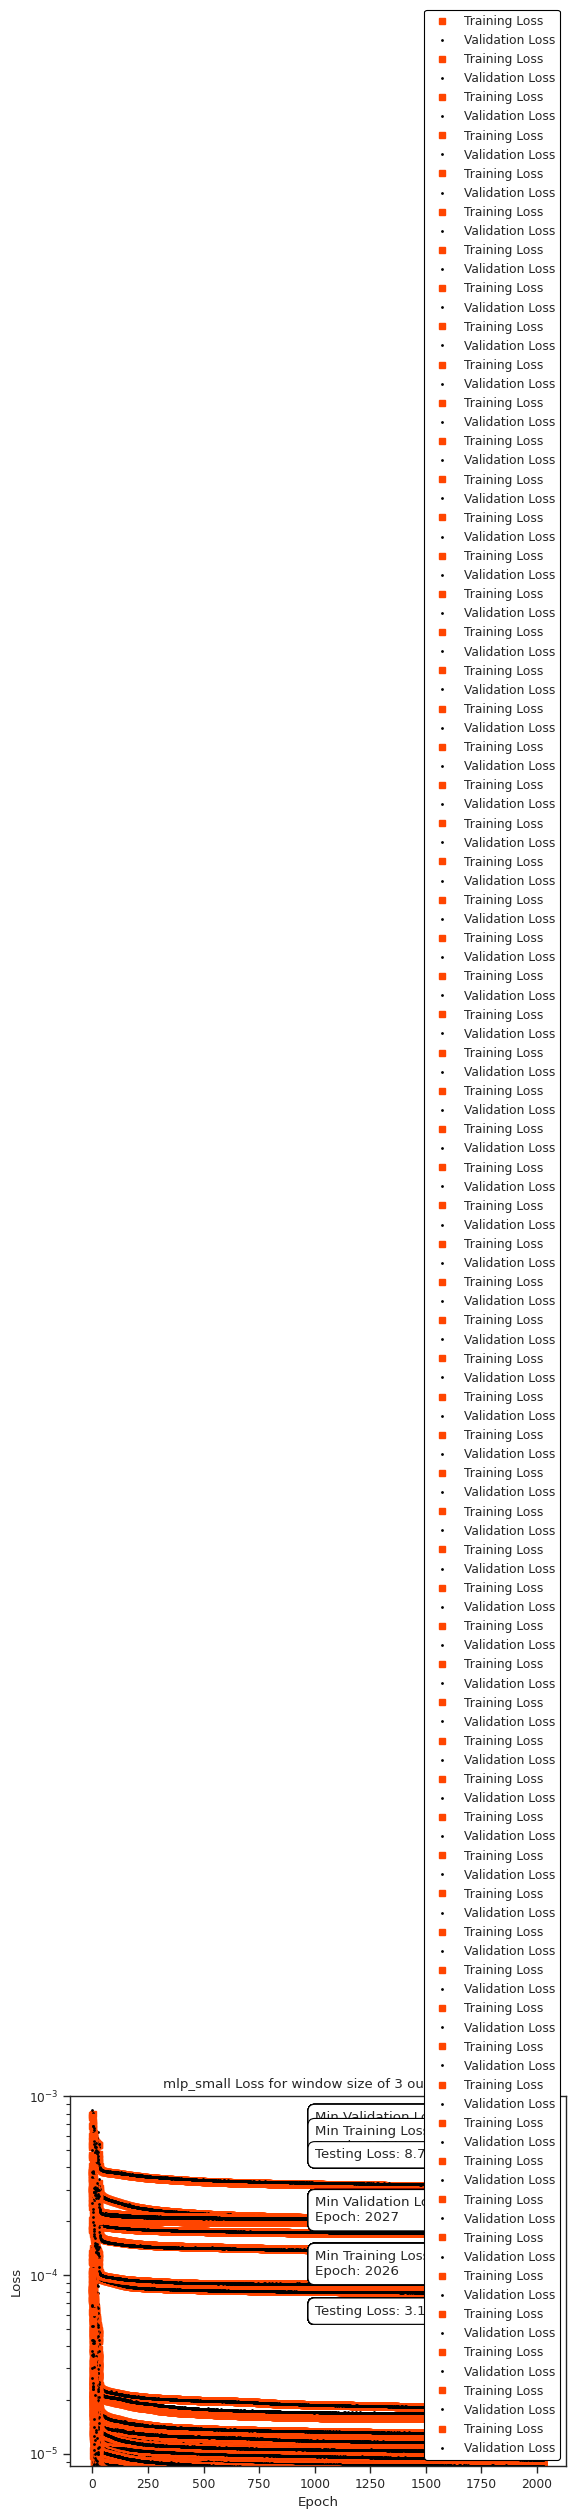

In [ ]:
for (old_cluster,version) in zip([7473664,7473665,7473666,7473667], ["0.0.0", "0.1.0", "0.1.1", "0.0.1"]):
    for fl in [16, 32]:
        # Load the data
        networks = ["mlp", "mlp_wide", "mlp_deep", "mlp_deep_wide", "mlp_conv", "conv1d", "conv2d", "depthwise_conv1d", "separable_conv2d", "separable_conv1d", "mlp_piecewise", "mlp_repeat", "mlp_big", "mlp_piecewise2", "lstm", "mlp_small"]
        
        if version[2] == "0":
            windowsize = 3
        else:
            windowsize = 4
        
        if version[-1] == "0":
            inpu = np.load(f"../../Data/test_data_{windowsize}/test_input.npy")
            inpu_id = np.load(f"../../Data/test_data_{windowsize}/test_id.npy")
        else:
            inpu = np.load(f"../../Data/test_data_{windowsize}_backwards/test_input.npy")
            inpu_id = np.load(f"../../Data/test_data_{windowsize}_backwards/test_id.npy")

        if version[-1] == "0":
            true_data = np.load(f"../../Data/test_data_{windowsize}/test_target.npy")
        else:
            true_data = np.load(f"../../Data/test_data_{windowsize}_backwards/test_target.npy")
        if fl != 16:
            minloss = []
            for i, network in enumerate(networks):
                loss = pickle.load(open(f"../../final/loss_info/{network}{old_cluster}.pkl", "rb"))
                # Calculate the test loss
                model = tf.keras.models.load_model(f"../../final/models/tensorflow/{network}_{version}_{old_cluster}", compile=False)
                model.load_weights(f"../../final/checkpoints/{network}{old_cluster}/{network}{old_cluster}")
                model.compile(optimizer='adam', loss='mse')
                if network == "mlp_small":
                    with tf.device('/CPU:0'):
                        testloss = model.evaluate(inpu, true_data, verbose=0)
                else:
                    with tf.device('/CPU:0'):
                        testloss = model.evaluate((inpu, inpu_id), true_data, verbose=0)
                plt.semilogy(loss['loss'],'s', color='orangered', label='Training Loss', markersize=4)
                plt.semilogy(loss['val_loss'],'o', color='k', label='Validation Loss', markersize=1)
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.ylim(0,1e-3)
                plt.legend()
                plt.grid()
                plt.title(network+f' Loss for window size of {windowsize}'+ (" inside-out" if version[-1]=="0" else " outside-in"))
                # Insert the minimum loss and the epoch at which it was achieved with 3 digit precision
                # make a box like the legend with the minimum loss and the epoch at which it was achieved with 3 digit precision
                if network == "separable_conv2d" or network == "mlp_small":
                    plt.text(1000, 6e-4, f"Min Validation Loss: {min(loss['val_loss']):.3g}\nEpoch: {np.argmin(loss['val_loss'])}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
                    plt.text(1000, 5e-4, f"Min Training Loss: {min(loss['loss']):.3g}\nEpoch: {np.argmin(loss['loss'])}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
                    plt.text(1000, 4.5e-4, f"Testing Loss: {testloss:.3g}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
                else:
                    plt.text(1000, 2e-4, f"Min Validation Loss: {min(loss['val_loss']):.3g}\nEpoch: {np.argmin(loss['val_loss'])}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
                    plt.text(1000, 1e-4, f"Min Training Loss: {min(loss['loss']):.3g}\nEpoch: {np.argmin(loss['loss'])}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
                    plt.text(1000, 6e-5, f"Testing Loss: {testloss:.3g}", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
                #plt.show()
                plt.savefig(f"../../final/loss_plot/{network}_{version}.pdf")
                #plt.close()
                print(f"Network: {network}")
                print(f"Loss: {min(loss['val_loss'])}")
                minloss.append(min(loss['val_loss']))
                print(f"Epoch: {np.argmin(loss['val_loss'])}")
        
        amount = 10_000
        if fl == 16:
            inpu = inpu.astype(np.float16)
            inpu_id = inpu_id.astype(np.float16)
        else:
            inpu = inpu.astype(np.float32)
            inpu_id = inpu_id.astype(np.float32)
            networks += ["dart1", "dart2", "rf1", "rf2", "gbdt1", "gbdt2"]
        stds = []
        for network in networks:
            if network != "dart1" and network != "dart2" and network != "rf1" and network != "rf2" and network != "gbdt1" and network != "gbdt2":
                if version[-1] == "0":
                    true_data = np.load(f"../../Data/test_data_{windowsize}/test_target.npy")
                else:
                    true_data = np.load(f"../../Data/test_data_{windowsize}_backwards/test_target.npy")
                true_data[:, 0] = true_data[:, 0] * 1015
                true_data[:, 1] = true_data[:, 1] * 1015
                true_data[:, 2] = true_data[:, 2] * 3000
                if fl == 16:
                    init_model = onnx.load(f"../../final/models/onnx/{network}_{version}_fp16_{old_cluster}.onnx")
                else:
                    init_model = onnx.load(f"../../final/models/onnx/{network}_{version}_{old_cluster}.onnx")
                ort_session = ort.InferenceSession(init_model.SerializeToString())
                # The input name is the name of the input layer
                input_dict = {}
                for i, name in enumerate(ort_session.get_inputs()):
                    if i == 0:
                        input_dict[name.name] = inpu.reshape(-1,*ort_session.get_inputs()[0].shape[1:])
                    if i == 1:
                        input_dict[name.name] = inpu_id.reshape(-1,*ort_session.get_inputs()[1].shape[1:])
                data = ort_session.run([ort_session.get_outputs()[0].name], input_dict)[0]
            elif network[-1] == "1":
                data = np.vstack((np.load(f"../../final/models/verstack/tuned0_predict_{network[:-1]}_{version}.npy"), np.load(f"../../final/models/verstack/tuned1_predict_{network[:-1]}_{version}.npy"), np.load(f"../../final/models/verstack/tuned2_predict_{network[:-1]}_{version}.npy"))).T
                true_data = np.vstack((np.load(f"../../final/models/verstack/y0_{version}.npy"), np.load(f"../../final/models/verstack/y1_{version}.npy"), np.load(f"../../final/models/verstack/y2_{version}.npy"))).T
                true_data[:, 0] = true_data[:, 0] * 1015
                true_data[:, 1] = true_data[:, 1] * 1015
                true_data[:, 2] = true_data[:, 2] * 3000

            elif network[-1] == "2":
                data = np.vstack((np.load(f"../../final/models/verstack/tuned01_predict_{network[:-1]}_{version}.npy"), np.load(f"../../final/models/verstack/tuned11_predict_{network[:-1]}_{version}.npy"), np.load(f"../../final/models/verstack/tuned21_predict_{network[:-1]}_{version}.npy"))).T
                true_data = np.vstack((np.load(f"../../final/models/verstack/y0_{version}.npy"), np.load(f"../../final/models/verstack/y1_{version}.npy"), np.load(f"../../final/models/verstack/y2_{version}.npy"))).T
                true_data[:, 0] = true_data[:, 0] * 1015
                true_data[:, 1] = true_data[:, 1] * 1015
                true_data[:, 2] = true_data[:, 2] * 3000
            else:
                raise ValueError("Network not found")

            # Run the model
            data[:, 0] = data[:, 0] * 1015
            data[:, 1] = data[:, 1] * 1015
            data[:, 2] = data[:, 2] * 3000
            
            std = np.std(data - true_data, axis=0)
            stds.append(std)
            mean = np.mean(data - true_data, axis=0)
            fig, ax = plt.subplots(1, 3, figsize=(12, 6))
            for j in range(3):
                sns.histplot(data[:, j] - true_data[:, j],bins=200, ax=ax[j], edgecolor='black', linewidth=0.5)
                ax[j].set_ylabel("")
                ax[j].set_title(f"{['x[mm]', 'y[mm]', 'z[mm]'][j]}")
                ax[j].set_yticklabels(ax[j].get_yticks(), rotation=45)        
                if j == 2:
                    ax[j].set_xlim(-50,50)
                else:
                    ax[j].set_xlim(-20,20)
                # Make a legend that shows the mean and std of the difference in x and y and z between the true and predicted values per axis   
                ax[j].legend([f"mean: {mean[j]:.2f}, std: {std[j]:.2f}"])
                ax[j].grid()
            # Make one x label and one y label for the whole figure
            fig.text(0.5, 0, 'Difference between predicted and true', ha='center')
            fig.text(0, 0.5, 'Count', va='center', rotation='vertical')
            # Make a title for the whole figure
            fig.suptitle(f"{network} performance for window size of {windowsize}" + (" inside-out" if version[-1] == "0" else " outside-in") + f" with float{fl}")
            plt.tight_layout()
            #plt.show()
            if fl == 16 and network != "dart1" and network != "dart2" and network != "rf1" and network != "rf2" and network != "gbdt1" and network != "gbdt2":
                plt.savefig(f"../../final/histogram/{network}_{version}_fp16.pdf")
            else:
                plt.savefig(f"../../final/histogram/{network}_{version}.pdf")
            plt.close()
        
            # Make a scatter plot of x and y axis of the true and predicted values with the true and predicted values as different colors and x and z


            fig, ax = plt.subplots(1, 2, figsize=(10, 6))

            ax[0].scatter(data[:amount, 0], data[:amount, 1], label="predicted", s=1)
            ax[0].scatter(true_data[:amount, 0], true_data[:amount, 1], label="true", s=1)
            ax[0].set_xlabel("x [mm]")
            ax[0].set_ylabel("y [mm]")
            ax[0].grid()
            ax[0].legend()


            ax[1].scatter(data[:amount, 2], np.sqrt(data[:amount, 0]**2 + data[:amount,1]**2), label="predicted", s=1)
            ax[1].scatter(true_data[:amount, 2], np.sqrt(true_data[:amount, 0]**2 + true_data[:amount,1]**2), label="true", s=1)
            ax[1].set_xlabel("z [mm]")
            ax[1].set_ylabel("r [mm]")
            ax[1].grid()
            ax[1].legend()
            fig.suptitle(f"{network} x-y and z-r scatter plot for window size of {windowsize}" + (" inside-out" if version[-1] == "0" else " outside-in") + f" with float{fl}")
            #plt.tight_layout()
            #plt.show()
            if fl == 16 and network != "dart1" and network != "dart2" and network != "rf1" and network != "rf2" and network != "gbdt1" and network != "gbdt2":
                plt.savefig(f"../../final/scatter_plot/{network}_{version}_fp16.pdf")
            else:
                plt.savefig(f"../../final/scatter_plot/{network}_{version}.pdf")
            plt.close()
            
        #make a bar plot of the stds using seaborn
        fig, ax = plt.subplots(3,1, figsize=(10, 18))
        for j in range(3):
            sns.barplot(x=networks, y=[std[j] for std in stds], ax=ax[j], linewidth=1.5, edgecolor="black", )
            ax[j].set_title(f"{['x[mm]', 'y[mm]', 'z[mm]'][j]}")
            if j == 2:
                ax[j].set_xlabel("Network")
            ax[j].set_ylabel("std")
            ax[j].set_xticklabels(networks, rotation=45, ha="right", fontsize=16)
            ax[j].set_ylim(0, 8)
            ax[j].grid()
            for p in ax[j].patches:
                ax[j].annotate(format(p.get_height(), '.3g'), 
                            (p.get_x() + p.get_width() / 2., np.amin([p.get_height()-0.4,7.5])), 
                            ha = 'center', va = 'center', 
                            xytext = (0, -10), 
                            textcoords = 'offset points',
                            color='white', rotation=90, fontsize=16)
        sns.despine(right=False, top=True)
        fig.suptitle(f"Standard deviation of the difference between predicted and true values for window size of {windowsize}" + (" inside-out" if version[-1] == "0" else " outside-in") + f" with float{fl}")
        plt.tight_layout()
        #plt.show()
        if fl == 16:
            plt.savefig(f"../../final/std_barplot/{version}_fp16.pdf")
        else:
            plt.savefig(f"../../final/std_barplot/{version}.pdf")
        plt.close()
    del init_model, ort_session, input_dict, data, true_data, inpu, inpu_id, minloss, loss, model, testloss, std, stds, mean
